In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import PIL
from urllib.request import urlretrieve
import urllib.request
import tarfile
import tempfile
import cv2
tf.get_logger().setLevel('ERROR')

### Load pre-trained InceptionV3 model

In [3]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=True)
model = keras.Model(inputs=base_model.input, outputs=base_model.output)

### Image preprocessing and Image classification function

In [4]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, (299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    
    # Predict class probabilities
    p = model.predict(img)[0]

    ax1.imshow(img[0]) 
    ax1.axis('off')

    # Get top-10 predictions
    topk = np.argsort(p)[-10:][::-1]
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)

    if target_class in topk:
        barlist[np.where(topk == target_class)[0][0]].set_color('r')
    if correct_class in topk:
        barlist[np.where(topk == correct_class)[0][0]].set_color('g')

    ax2.set_ylim([0, 1.1])
    ax2.set_xticks(range(10))
    ax2.set_xticklabels([imagenet_labels[str(i)][1][:15] for i in topk], rotation='vertical')
    plt.subplots_adjust(bottom=0.2)
    plt.show()

### Define ImageNet labels

In [5]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
filename = 'imagenet_class_index.json'

urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    imagenet_labels = json.load(f)

### Image test before modification

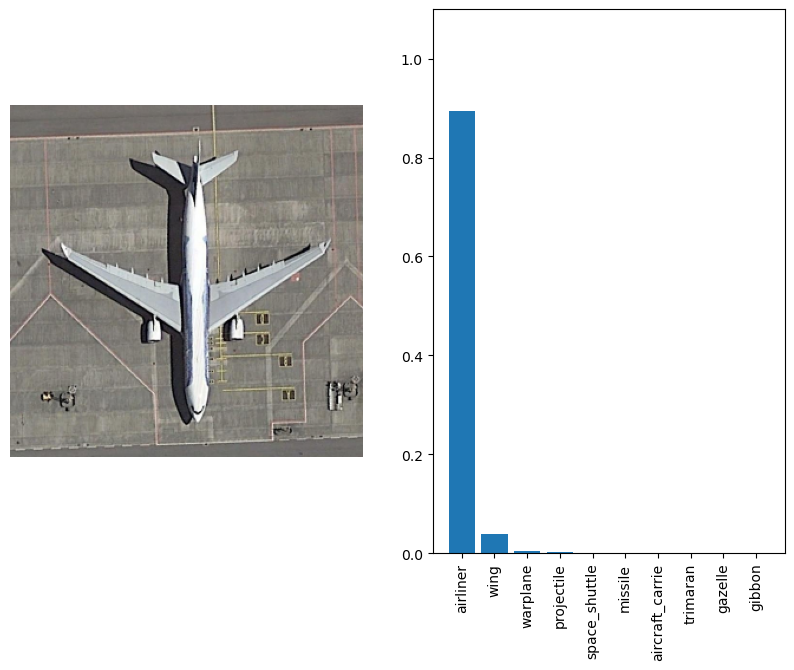

In [6]:
img_path = './images/plane.PNG'
img_class = 404
img = preprocess_image(img_path)
classify(img)

### Adversarial attack function

In [7]:
def adversarial_attack(img, correct_class, target_class, demo_lr, demo_steps, demo_epsilon):
    # Initialize adversarial input as a trainable variable
    x_hat = tf.Variable(img, dtype=tf.float32)

    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(demo_lr)

    # Start adversarial attack
    for step in range(demo_steps):
        with tf.GradientTape() as tape:
            tape.watch(x_hat)

            # Model predictions for the current adversarial input
            logits = model(x_hat)
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[target_class])

        # Compute gradients
        grads = tape.gradient(loss, x_hat)

        # Apply gradients (optimization step)
        optimizer.apply_gradients([(grads, x_hat)])

        # Adversarial perturbation projection (clipping)
        x_hat.assign(tf.clip_by_value(x_hat, img - demo_epsilon, img + demo_epsilon))

        if (step + 1) % 10 == 0:
            print(f'Step {step + 1}, Loss: {loss.numpy()}')

    # Return adversarial image
    adv_image = tf.clip_by_value(x_hat, 0.0, 1.0)
    return adv_image

In [18]:
demo_target = 282  # target class for attack
demo_lr = 5e-2
demo_steps = 100
demo_epsilon = 2.0 / 255.0

In [19]:
adv_img = adversarial_attack(img, correct_class=img_class, target_class=demo_target, 
                             demo_lr=demo_lr, demo_steps=demo_steps, demo_epsilon=demo_epsilon)

Step 10, Loss: [6.9059625]
Step 20, Loss: [6.9086833]
Step 30, Loss: [6.9083333]
Step 40, Loss: [6.9074955]
Step 50, Loss: [6.8955398]
Step 60, Loss: [6.3149242]
Step 70, Loss: [5.910967]
Step 80, Loss: [5.910048]
Step 90, Loss: [5.909773]
Step 100, Loss: [5.909644]


### Classify the adversarial image

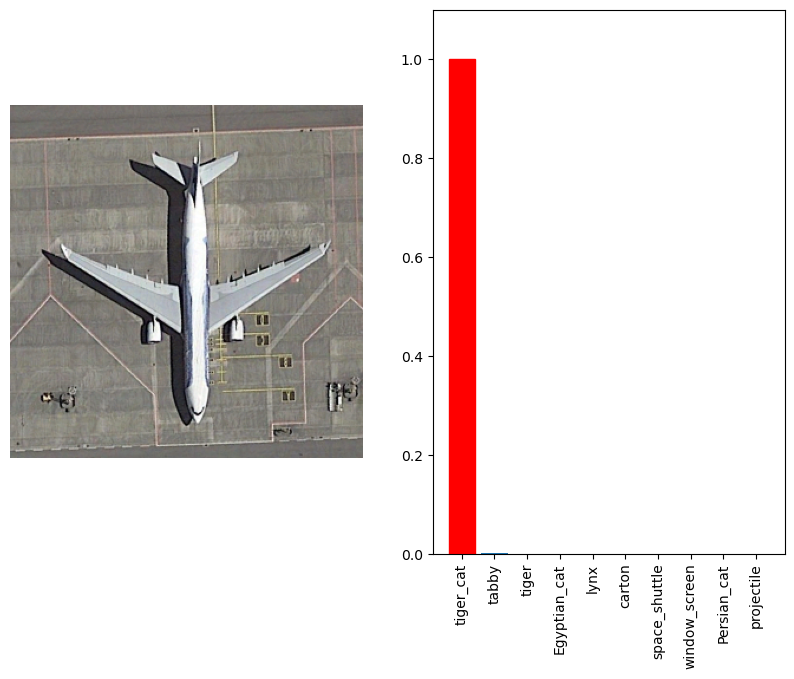

In [20]:
classify(adv_img, correct_class=img_class, target_class=demo_target)

### Rotate adversarial image

In [11]:
ex_angle = np.pi / 3.2  # Angle in radians
rotated_example = tfa.image.rotate(adv_img, ex_angle)

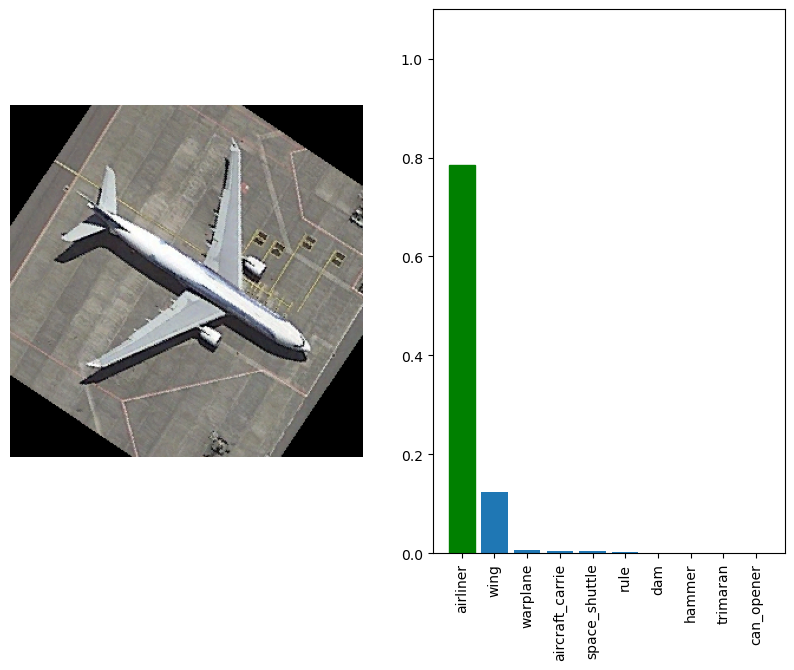

In [12]:
classify(rotated_example, correct_class=img_class, target_class=demo_target)

# Resistance to rotation

### Parameters

In [41]:
num_samples = 10
average_loss = 0
demo_lr = 2e-2
demo_epsilon = 16.0 / 255.0 
demo_steps = 600
demo_target = 282

### Image preparation

In [42]:
img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
adv_img2 = tf.Variable(img_tensor) 

### Compute the average loss over randomly rotated images

In [43]:
for i in range(num_samples):
    rotated = tfa.image.rotate(
        adv_img2, tf.random.uniform((), minval=-np.pi / 4, maxval=np.pi / 4)
    )
    rotated_logits = base_model(rotated, training=False)  
    average_loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=tf.one_hot(demo_target, 1000))) / num_samples

### Adversarial attack loop

In [44]:
for i in range(num_samples):
    rotated = tfa.image.rotate(
        adv_img2, tf.random.uniform((), minval=-np.pi / 4, maxval=np.pi / 4)
    )
    rotated_logits = base_model(rotated, training=False)
    average_loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=tf.one_hot(demo_target, 1000))) / num_samples

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=demo_lr)

for i in range(demo_steps):
    with tf.GradientTape() as tape:
        tape.watch(adv_img2)  # Track adversarial image for gradient computation

        # Apply a random rotation at each iteration
        rotated = tfa.image.rotate(
            adv_img2, tf.random.uniform((), minval=-np.pi/4, maxval=np.pi/4),
            interpolation='NEAREST'
        )

        logits = base_model(rotated, training=False)
        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(demo_target, 1000), logits=logits
        )

    grads = tape.gradient(loss, adv_img2)

    if grads is not None:
        optimizer.apply_gradients([(grads, adv_img2)])
        adv_img2.assign(tf.clip_by_value(adv_img2, img_tensor - demo_epsilon, img_tensor + demo_epsilon))

    if (i + 1) % 50 == 0:
        diff = tf.reduce_mean(tf.abs(adv_img2 - img_tensor)).numpy()
        print(f"Step {i+1}, Loss: {loss.numpy()}, Mean Perturbation: {diff}")

Step 50, Loss: [6.883619], Mean Perturbation: 0.0480620451271534
Step 100, Loss: [5.9427805], Mean Perturbation: 0.04730994999408722
Step 150, Loss: [5.9115067], Mean Perturbation: 0.04581548646092415
Step 200, Loss: [5.909961], Mean Perturbation: 0.04500453919172287
Step 250, Loss: [5.9097853], Mean Perturbation: 0.043995171785354614
Step 300, Loss: [5.909709], Mean Perturbation: 0.043914325535297394
Step 350, Loss: [5.9096794], Mean Perturbation: 0.04387103393673897
Step 400, Loss: [5.9096127], Mean Perturbation: 0.04383649304509163
Step 450, Loss: [5.909544], Mean Perturbation: 0.043813493102788925
Step 500, Loss: [5.9095016], Mean Perturbation: 0.04379661753773689
Step 550, Loss: [5.909601], Mean Perturbation: 0.04378305375576019
Step 600, Loss: [5.9095573], Mean Perturbation: 0.04376685246825218


### Rotate adversarial image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0627451..1.0627451].


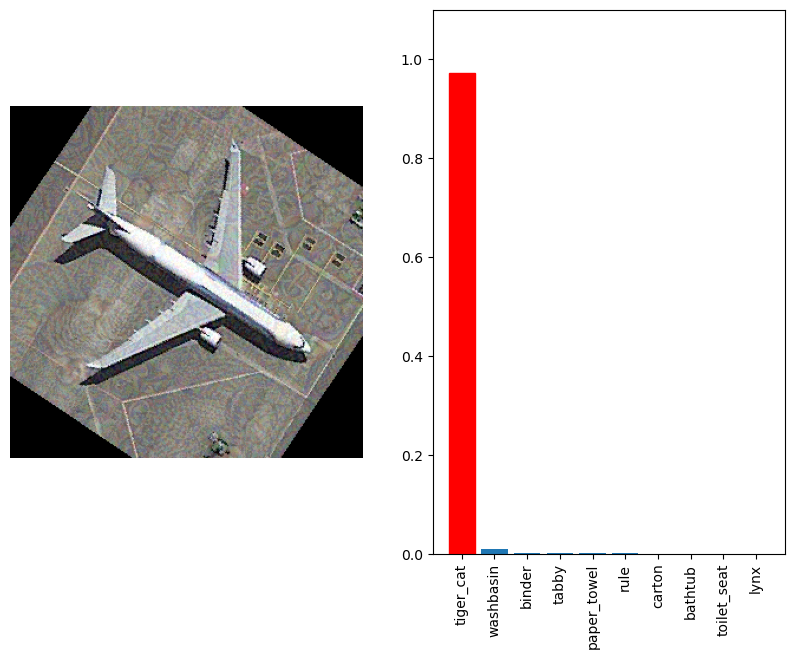

In [45]:
ex_angle = np.pi / 3.2  # Angle in radians 
rotated_example = tfa.image.rotate(adv_img2, ex_angle)

classify(rotated_example, correct_class=img_class, target_class=demo_target)